In [1]:
## Imports

In [2]:
%matplotlib inline
import os
import cv2
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from components.RadarLoader import RadarLoader
from components.SimulatedRadar import SimulatedRadar

from brian2 import *

seq_name = "2019-09-16-12-58-42"
%run carrada_utils/scripts/set_path.py '/Volumes/SAMSUNG/Carrada/'

In [3]:
SIZE_X = 64
SIZE_Y = 64
INPUT_WEIGHT = 1.0
TIME_BETWEEN_FRAMES = 100.0
DATA_FREQ_MULTIPLIER=2.0
TAU = 200 # ms
GRID_DISTANCE=100.0
SIGMA_EXC = 1.0 # 5?
SIGMA_INH = 10.0
CONN_CUTOFF=120
INTENSITY_EXC = 1.0
INTENSITY_INH = -10.0

In [4]:
data_loader = RadarLoader(seq_name)
sim_data_loader = SimulatedRadar()


In [5]:


raw_data, size_bf = data_loader.get_range_angle_stream_data(clip_and_normalize=True, resize=(SIZE_X,SIZE_X))
raw_camera_data = data_loader.get_color_image_datastream(resize=(SIZE_X,SIZE_Y))
spiking_data, spiking_indices = data_loader.get_spiking_ra_stream_differentiated_normalized_brian2(size_x=SIZE_X, time_bw_frames=TIME_BETWEEN_FRAMES, data_factor=DATA_FREQ_MULTIPLIER)

sim_spiking_data, sim_spiking_indices = sim_data_loader.get_random_datastream_spiking_brian2(size_x=SIZE_X)
ds = sim_data_loader.get_random_datastream()

dense_, sparse_, box_, sp_mp_, sp_mp_vis_ = data_loader.visualize_annotations(differentiated=True, size_bf=size_bf, size_x_=(SIZE_X, SIZE_Y))

print(f"Total nr of frames: {(len(raw_camera_data))}")

HERE
Total nr of frames: 927


In [6]:
# np.save("raw_data.npy", np.asanyarray(raw_data))
# #np.save("raw_camera_data.npy", np.asanyarray(raw_camera_data))
# np.save("spiking_data.npy", np.asanyarray(spiking_data))
# np.save("spiking_indices.npy", np.asanyarray(spiking_indices))
# np.save("dense_.npy", np.asanyarray(dense_))
len(ds)

112

In [7]:
#raw_data = np.load("raw_data.npy")
#raw_camera_data = np.load("raw_camera_data.npy")
#spiking_data = np.load("spiking_data.npy")
#spiking_indices = np.load("spiking_indices.npy")
#dense_ = np.load("dense_.npy")

In [8]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
# set_device('cpp_standalone', build_on_run=False)    

In [9]:
#device.reinit()
#device.activate()
#device.delete(force=True)



In [10]:
#set_device('cpp_standalone')#, build_on_run=False)    

start_scope()
tau = TAU*ms

eqs = '''
dv/dt = -v/tau : 1
x : meter
y : meter
'''

N = SIZE_X*SIZE_Y
rows = SIZE_X
cols = SIZE_Y
# initialize the grid positions
grid_dist = GRID_DISTANCE*umeter
sigma_exc = SIGMA_EXC*grid_dist
sigma_inh = SIGMA_INH*grid_dist
intensity_exc = INTENSITY_EXC/(2*math.pi*SIGMA_EXC**2)
intensity_inh = INTENSITY_INH/(2*math.pi*SIGMA_INH**2)
conn_distance = CONN_CUTOFF*grid_dist
lower_volt_thresh = -1.0
higher_volt_thresh = 1.0
G = NeuronGroup(N, eqs, threshold='v>1.0', reset='v = 0.0', method='exact')
G.x = '(i // rows) * grid_dist - rows/2.0 * grid_dist'
G.y = '(i % rows) * grid_dist - cols/2.0 * grid_dist'

# Synapses
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(condition='(i!=j) and (sqrt((x_pre - x_post)**2 + (y_pre - y_post)**2) < conn_distance)')
# Weight varies with distance
S.w = '(intensity_exc*exprel(-((x_pre - x_post)**2 + (y_pre - y_post)**2)/(2*(sigma_exc**2))))'

S_inhib = Synapses(G, G, 'w : 1', on_pre='v_post = clip((w + v_post), lower_volt_thresh, inf)') # TODO: inf oder eins??
S_inhib.connect(condition='(i!=j) and (sqrt((x_pre - x_post)**2 + (y_pre - y_post)**2) < conn_distance)')
# Weight varies with distance
S_inhib.w =  '(intensity_inh*exprel(-((x_pre - x_post)**2 + (y_pre - y_post)**2)/(2*(sigma_inh**2))))'


G_input = SpikeGeneratorGroup(N, spiking_indices, spiking_data*ms)
weight=INPUT_WEIGHT# 0.1 works
S_input = Synapses(G_input, G, on_pre='v += weight')
S_input.connect(i='j')


In [11]:
M_spike = SpikeMonitor(G)
M_spike_input = SpikeMonitor(G_input)

M_state = StateMonitor(G, 'v', record=True)



In [12]:
run((len(raw_camera_data)-1)*TIME_BETWEEN_FRAMES*ms, report="stdout", report_period=10000*ms)


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'v_post = clip(w + v_post, lower_volt_thresh, inf)'
 [brian2.codegen.generators.base]


Starting simulation at t=0.0 for a duration of 92.60000000000001
6.5537 s (7%) simulated in 14s, estimated 3m 8s remaining.
13.1073 s (14%) simulated in 30s, estimated 3m 7s remaining.
17.1848 s (18%) simulated in 40s, estimated 2m 59s remaining.
19.51 s (21%) simulated in 50s, estimated 3m 11s remaining.
22.9694 s (24%) simulated in 1m 0s, estimated 3m 5s remaining.
26.2145 s (28%) simulated in 1m 52s, estimated 4m 45s remaining.
35.3291 s (38%) simulated in 2m 2s, estimated 3m 19s remaining.
43.3047 s (46%) simulated in 2m 12s, estimated 2m 31s remaining.
46.3081 s (50%) simulated in 2m 22s, estimated 2m 22s remaining.
48.2958 s (52%) simulated in 2m 32s, estimated 2m 20s remaining.
49.5527 s (53%) simulated in 2m 42s, estimated 2m 21s remaining.
52.4289 s (56%) simulated in 6m 18s, estimated 4m 50s remaining.
59.8854 s (64%) simulated in 6m 28s, estimated 3m 32s remaining.
68.5666 s (74%) simulated in 6m 38s, estimated 2m 20s remaining.
74.6497 s (80%) simulated in 6m 48s, estimated

In [13]:
numpy.set_printoptions(threshold=sys.maxsize)
npdense_ = np.array(dense_)
npdense_[npdense_ < 0.1] = -0.01
npdense_[npdense_ >= 0.1] = 0.1

npdense_vis = np.array(dense_)
npdense_vis[npdense_vis < 0.1] = 0.0
npdense_vis[npdense_vis >= 0.1] = 1.0


spike_times_plot = np.array(M_spike.t/ms)
spike_index_plot = np.array(M_spike.i)

input_spike_times_plot = np.array(M_spike_input.t/ms)
input_spike_index_plot = np.array(M_spike_input.i)


input_spike_map_data = []
output_spike_map_data = []
eval_spike_map_data_dense = []

eval_spikes_perf = []



for i in range(0,len(npdense_vis)):
    grid_input = np.zeros((SIZE_X,SIZE_X))
    grid_output = np.zeros((SIZE_X,SIZE_X))
    for ind_ in spike_index_plot[(i*100.0 < spike_times_plot) & (spike_times_plot < i*100.0+100.0)]:
        grid_output[ind_//SIZE_X][ind_%SIZE_X]+=1
    for ind_ in input_spike_index_plot[(i*100.0< input_spike_times_plot) & (input_spike_times_plot < i*100.0+100.0)]:
        grid_input[ind_//SIZE_X][ind_%SIZE_X]+=1
    
    temp__ = (npdense_[i] * grid_output)
    if np.sum(temp__) > 0:
        eval_spike_map_data_dense.append(temp__/np.max(temp__))
    else:
        eval_spike_map_data_dense.append(temp__+0.00001)
    if np.sum(dense_[i]) > 0:
        eval_spikes_perf.append(temp__)
    input_spike_map_data.append((grid_input).copy())
    output_spike_map_data.append((grid_output).copy())


In [14]:

t_sum_eval = np.sum(np.sum(eval_spikes_perf, axis=1), axis=1)
t_sum_eval_all = np.sum(np.sum(eval_spike_map_data_dense, axis=1), axis=1)
eval_score_final = np.sum(t_sum_eval)/len(t_sum_eval)

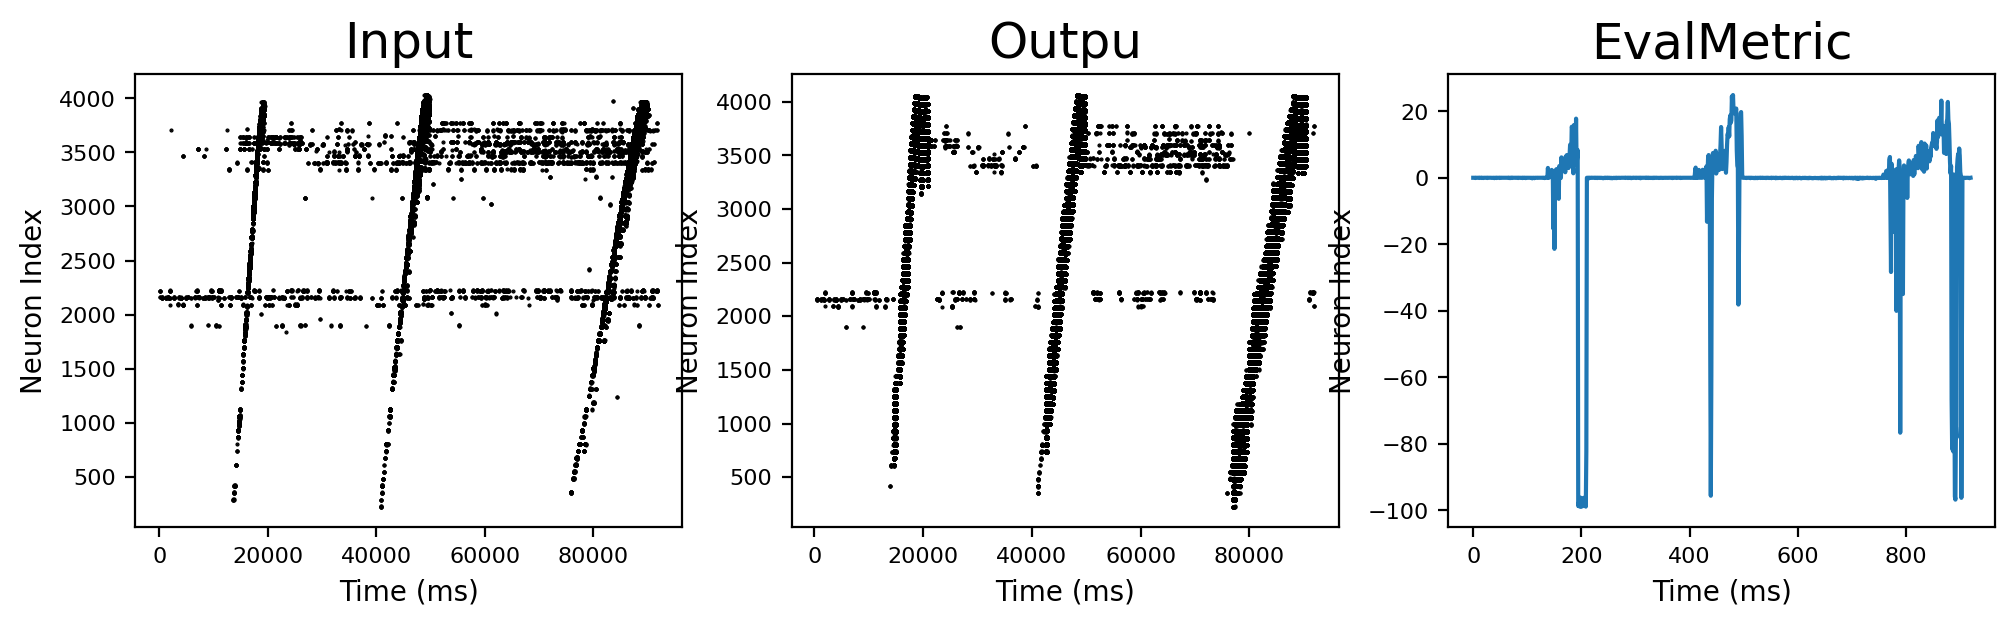

In [15]:
#210.0 in spikes_in.segments[0].spiketrains[37].times
fig2,(ax_1, ax_2, ax_3)= plt.subplots(1, 3, figsize=(12,3), dpi=200)

#ax_1.tick_params(axis='both',labelsize=8)
ax_1.set_title("Input", fontsize=18)
input_spike_train_plot = ax_1.plot(M_spike_input.t/ms, M_spike_input.i, '.k', ms=1)
ax_1.set_xlabel('Time (ms)', fontsize=10)
ax_1.set_ylabel('Neuron Index', fontsize=10)
ax_1.tick_params(axis='both',labelsize=8)

ax_2.set_title("Outpu",fontsize=18)
input_spike_train_plot = ax_2.plot(M_spike.t/ms, M_spike.i, '.k', ms=1)
ax_2.set_xlabel('Time (ms)',fontsize=10)
ax_2.set_ylabel('Neuron Index', fontsize=10)
ax_2.tick_params(axis='both',labelsize=8)

ax_3.set_title("EvalMetric",fontsize=18)
input_spike_train_plot = ax_3.plot(t_sum_eval_all)
ax_3.set_xlabel('Time (ms)',fontsize=10)
ax_3.set_ylabel('Neuron Index', fontsize=10)
ax_3.tick_params(axis='both',labelsize=8)


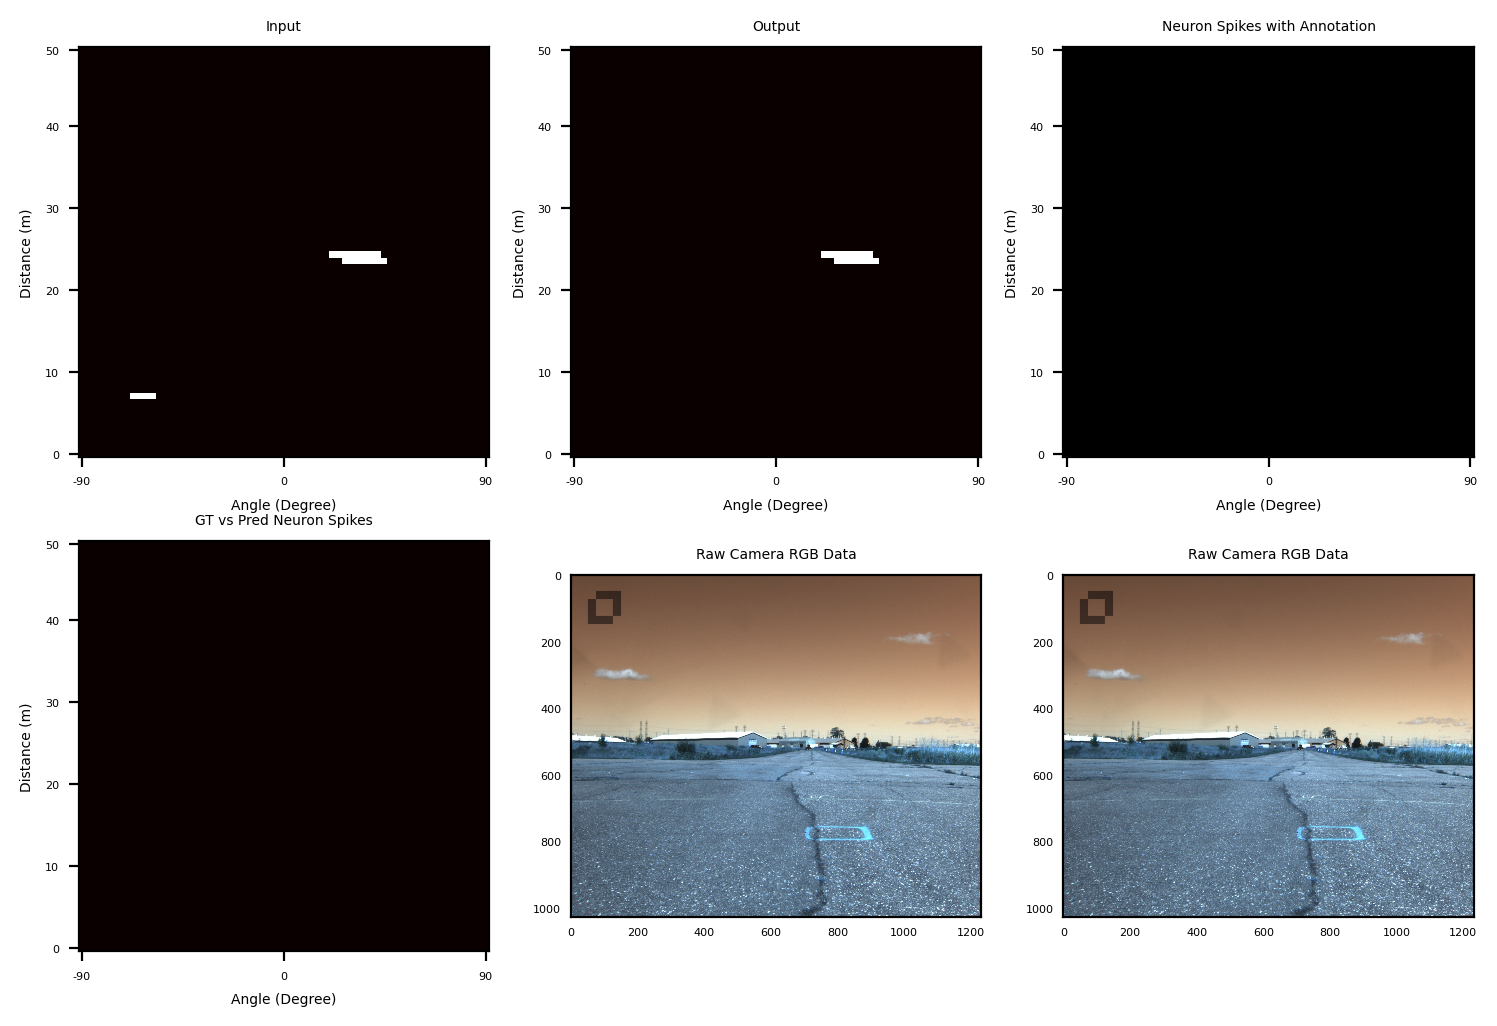

In [16]:
grid_input_mock = np.zeros((SIZE_X,SIZE_X))
grid_output_mock = np.zeros((SIZE_X,SIZE_X))
for ind_ in spike_index_plot[(4000< spike_times_plot) & (spike_times_plot < 5100.0)]:
    grid_output_mock[ind_//SIZE_X][ind_%SIZE_X]+=1
for ind_ in input_spike_index_plot[(4000 < input_spike_times_plot) & (input_spike_times_plot < 5100.0)]:
    grid_input_mock[ind_//SIZE_X][ind_%SIZE_X]+=1
                        

fig,((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(2, 3, figsize=(9,6), dpi=200)

# Input spikes
ax1.tick_params(axis='both',labelsize=4)
ax1.set_title("Input",fontsize=5)
input_map = ax1.imshow(np.array(grid_input_mock), cmap='hot', interpolation='none')

ax1.set_xticks([0, (SIZE_X-1)/2, SIZE_X-1])
ax1.set_yticks([0,
               SIZE_X*1/5-1,
               SIZE_X*2/5-1,
               SIZE_X*3/5-1,
               SIZE_X*4/5-1,
               SIZE_X-1])

ax1.set_yticklabels([50, 40, 30, 20, 10, 0])
ax1.set_xticklabels([-90, 0, 90])
ax1.set_ylabel('Distance (m)', fontsize=5)
ax1.set_xlabel('Angle (Degree)', fontsize=5)

# Output neuron Spikes
ax2.tick_params(axis='both',labelsize=4)
ax2.set_title(f"Output",fontsize=5)

output_map = ax2.imshow(np.array(grid_output_mock), cmap='hot', interpolation='none')

ax2.set_xticks([0, (SIZE_X-1)/2, SIZE_X-1])
ax2.set_yticks([0,
               SIZE_X*1/5-1,
               SIZE_X*2/5-1,
               SIZE_X*3/5-1,
               SIZE_X*4/5-1,
               SIZE_X-1])
ax2.set_yticklabels([50, 40, 30, 20, 10, 0])
ax2.set_xticklabels([-90, 0, 90])
ax2.set_ylabel('Distance (m)', fontsize=5)
ax2.set_xlabel('Angle (Degree)', fontsize=5)

# Annotated Neuron Activities
ax3.tick_params(axis='both',labelsize=4)
ax3.set_title("Neuron Spikes with Annotation",fontsize=5)

annotated_neuron_act = np.zeros((len(npdense_vis), 64,64,3))
annotated_neuron_act[:,:,:,0] = (np.array(output_spike_map_data) / np.max(np.array(output_spike_map_data)))
annotated_neuron_act[:,:,:,1] = np.array(npdense_vis)

spike_map_w_annot = ax3.imshow(np.array(annotated_neuron_act[0]), cmap='hot', interpolation='none')

ax3.set_xticks([0, (SIZE_X-1)/2, SIZE_X-1])
ax3.set_yticks([0,
               SIZE_X*1/5-1,
               SIZE_X*2/5-1,
               SIZE_X*3/5-1,
               SIZE_X*4/5-1,
               SIZE_X-1])
ax3.set_yticklabels([50, 40, 30, 20, 10, 0])
ax3.set_xticklabels([-90, 0, 90])
ax3.set_ylabel('Distance (m)', fontsize=5)
ax3.set_xlabel('Angle (Degree)', fontsize=5)

# GT vs Pred Neuron Spikes
ax4.tick_params(axis='both',labelsize=4)
ax4.set_title("GT vs Pred Neuron Spikes",fontsize=5)

eval_spike_map = ax4.imshow(np.array(eval_spike_map_data_dense[0]), cmap='hot', interpolation='none')

ax4.set_xticks([0, (SIZE_X-1)/2, SIZE_X-1])
ax4.set_yticks([0,
               SIZE_X*1/5-1,
               SIZE_X*2/5-1,
               SIZE_X*3/5-1,
               SIZE_X*4/5-1,
               SIZE_X-1])
ax4.set_yticklabels([50, 40, 30, 20, 10, 0])
ax4.set_xticklabels([-90, 0, 90])
ax4.set_ylabel('Distance (m)', fontsize=5)
ax4.set_xlabel('Angle (Degree)', fontsize=5)

# Raw RGB Camera data
ax5.tick_params(axis='both',labelsize=4)
ax5.set_title("Raw Camera RGB Data",fontsize=5)
rgb_cam_data_plot = ax5.imshow(np.array(raw_camera_data[1]), interpolation='none')

ax5.tick_params(axis=u'both', which=u'both',length=0)


# Raw RGB Camera data
ax6.tick_params(axis='both',labelsize=4)
ax6.set_title("Raw Camera RGB Data",fontsize=5)
rgb_cam_data_2_plot = ax6.imshow(np.array(raw_camera_data[1]), interpolation='none')

ax6.tick_params(axis=u'both', which=u'both',length=0)






In [17]:
def init():
    input_map.set_data(np.array(input_spike_map_data[0]))
    output_map.set_data(np.array(output_spike_map_data[0]))
    spike_map_w_annot.set_data(np.array(annotated_neuron_act[0]))
    eval_spike_map.set_data(np.array(eval_spike_map_data_dense[0]))
#     rgb_cam_data_plot.set_data(np.array(raw_camera_data[1]))
    rgb_cam_data_2_plot.set_data(np.array(raw_camera_data[1]))

    
    return [input_map, output_map, spike_map_w_annot, eval_spike_map, rgb_cam_data_2_plot]


# animation function.  This is called sequentially
def animate(i):
    input_map.set_data(np.array(input_spike_map_data[i]))
    output_map.set_data(np.array(output_spike_map_data[i]))
    spike_map_w_annot.set_data(np.array(annotated_neuron_act[i]))
    eval_spike_map.set_data(np.array(eval_spike_map_data_dense[i]))
#     rgb_cam_data_plot.set_data(np.array(raw_camera_data[i]))
    rgb_cam_data_2_plot.set_data(np.array(raw_camera_data[i]))
    return [input_map, output_map, spike_map_w_annot, eval_spike_map, rgb_cam_data_2_plot]


FFwriter = animation.FFMpegWriter(fps=10, extra_args=["-vcodec", "libx264"])
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=len(dense_)-1, interval=1, blit=True
)

anim.save(f"animations/notebook__eval3_{int(eval_score_final)}_tau_{int(TAU)}_sigma_{int(10*SIGMA_EXC)}_inExc_{int(10*INTENSITY_EXC)}_inInh_{int(INTENSITY_INH)}_cutoff_{int(CONN_CUTOFF)}.mp4", FFwriter)

In [18]:
%matplotlib inline
import matplotlib
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128
HTML(anim.to_jshtml())


In [19]:

device.delete(force=True)

